In [533]:
% reset
% config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy as sp
import statsmodels.api as sm
from scipy import stats
from scipy import signal

import h5py

from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import foof_utils as fu

% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 12
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [534]:
# load the data and pick a channel
chandat = np.loadtxt("ecog_data.csv", delimiter=",")
chandat = chandat[:, 1]

# make the PSD
srate = 1000.0
window_size = int(srate*5)
overlap = int(window_size * 0.5)

xf, _, psd_array = signal.spectrogram(chandat, fs=srate, window=('hanning'), nperseg=window_size, noverlap=overlap)
psd_array = np.log10(psd_array)

# plt.plot(xf, np.mean(psd_array, 1))
# plt.show()


In [495]:
# simulate spectrum as opposed to using real data

frequency_vector = np.linspace(1, 36, 1000)
slope_params = [5.11, -0.0567, 0.00059]
oscillation_params = [[0.53, 7.98, 1.7],[0.33, 12.3, 2.3],[0.13, 23.1, 3.3]]
noise = [0.0, 0.1]

res = stats.mode(np.diff(frequency_vector))[0]

number_of_samples = 100

psd_array = fu.simulate_neural_spectra(frequency_vector, slope_params, oscillation_params, noise)

for i in range(number_of_samples-1):
    simulated_spectrum = fu.simulate_neural_spectra(frequency_vector, slope_params, oscillation_params, noise)
    psd_array = np.vstack((psd_array, simulated_spectrum))  

psd_array = psd_array.T    

xf = frequency_vector

In [535]:
# helper functions

def get_index_from_vector(input_vector, element_value):
    loc = input_vector-element_value
    idx = np.where(np.abs(loc)==np.min(np.abs(loc)))
    idx = idx[0][0]
    
    return idx

def trim_psd(input_psd, input_frequency_vector, frequency_range):
    idx = [0, 0]
    idx[0] = get_index_from_vector(input_frequency_vector, frequency_range[0])
    idx[1] = get_index_from_vector(input_frequency_vector, frequency_range[1])

    output_frequency_vector = input_frequency_vector[idx[0]:idx[1]]
    trimmed_psd = input_psd[idx[0]:idx[1], :]
    
    return output_frequency_vector, trimmed_psd

# gaussian function
def gaussian_function(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

def fit_gaussian(flattened_psd, frequency_vector, window_around_max):

    # find the location and amplitude of the maximum of the flattened spectrum
    # this assumes that this value is the peak of the biggest oscillation
    max_index = np.argmax(flattened_psd)
    guess_freq = frequency_vector[max_index]

    # set everything that's not the biggest oscillation to zero
    p_flat_zeros = flattened_psd - 0
    p_flat_zeros[0:(max_index-window_around_max)] = 0
    p_flat_zeros[(max_index+window_around_max):,] = 0

    # the first guess for the gaussian fit is the biggest oscillation
    guess = [guess_freq, np.max(p_flat_zeros), 2]
    guess = np.array(guess)
    popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_zeros, p0=guess)
    gaussian_fit = gaussian_function(frequency_vector, *popt)
    gaussian_fit = np.array(gaussian_fit)        

    return popt, gaussian_fit

In [536]:
cut_freqs = [2, 35]
proportion_test = 0.5

def fooof(frequency_vector, input_psd, frequency_range, proportion_test, number_of_gaussians):
    
    if input_psd.ndim>2:
        raise ValueError("input PSD must be 1- or 2- dimensional")
        
    # initialize
    fit_r2 = np.ndarray(0)
    oscillation_params = np.empty((0,3)) # cf, amp, bw
        
    res = stats.mode(np.diff(frequency_vector))[0] # frequency resolution
    window_around_max = 4 # in Hz
    window_around_max = np.floor(4/res)
    window_around_max = int(window_around_max[0])
    
    # trim the PSD
    frequency_vector, foof_spec = trim_psd(psd_array, frequency_vector, frequency_range)
    
    gaussian_fit = np.empty((0,np.size(frequency_vector)))

    # check dimensions
    if np.shape(frequency_vector)[0]==np.shape(foof_spec)[0]:
        foof_spec = foof_spec.T

    # split into training and test sets
    spec_train, spec_test = train_test_split(foof_spec, test_size=proportion_test)
    psd_train = np.mean(spec_train,0)
    psd_test = np.mean(spec_test,0)

    train_data = np.mean(spec_train,0)
    test_data = np.mean(spec_test,0)

    # add noise to PSD to see how robust the fitting is
    # train_data = train_data + np.random.normal(0, 0.05, np.size(train_data))

    # 2nd degree polynomial robust fit for first pass
    Xvar = np.column_stack((frequency_vector, frequency_vector**2))
    Xvar = sm.add_constant(Xvar)
    mdl_fit = sm.RLM(train_data, Xvar, M=sm.robust.norms.HuberT()).fit()

    # flatten PSD
    p_flat = train_data - mdl_fit.fittedvalues
    
    # remove outliers
    p_flat[p_flat<0] = 0
    cutoff = p_flat<=(np.max(p_flat)*0.025)
    f_ignore = frequency_vector[cutoff]
    p_ignore = train_data[cutoff]

    # refit the background, ignoring regions with large amplitudes
    # this assumes those large amplitude regions are oscillations, not background
    Xvar = np.column_stack((f_ignore, f_ignore**2))
    Xvar = sm.add_constant(Xvar)
    mdl_fit = sm.RLM(p_ignore, Xvar, M=sm.robust.norms.HuberT()).fit()

    background_params = mdl_fit.params
    
    background_fit = background_params[0] + (background_params[1]*(frequency_vector)) + (background_params[2]*(frequency_vector**2))
    p_flat_real = train_data - background_fit
    p_flat_real[p_flat_real<0] = 0
    p_flat_iteration = p_flat_real - 0
    
    # the R2 between the model with only the background vs the data
    r,_ = stats.pearsonr(test_data,background_fit)
    fit_r2 = np.append(fit_r2, r**2)
    
    # first fit
    for i in range(number_of_gaussians):
        try:
            if i == 0:
                popt, output_gaussian = fit_gaussian(p_flat_real, frequency_vector, window_around_max)
            else:
                popt, output_gaussian = fit_gaussian(p_flat_iteration, frequency_vector, window_around_max)
            oscillation_params = np.vstack((oscillation_params, popt))
            
            gaussian_fit = np.vstack((gaussian_fit, output_gaussian))
            temp_fit = np.sum(gaussian_fit,0)+background_fit
            r,_ = stats.pearsonr(test_data,temp_fit)
            fit_r2 = np.append(fit_r2, r**2)
            # remove the biggest oscillation from the flattened spectrum
            p_flat_iteration = p_flat_real - np.sum(gaussian_fit,0)
        except:
            pass # this needs exception handling in case fitting fails
        
    # filter out unrealistic oscillations
    background_std = psd_train-np.sum(gaussian_fit,0)-background_fit # flatten and remove fits
    background_std = np.std(background_std)*1.645 # get the std of the residuals

    # amp has to be at least 1.645 * residual noise
    # std of gaussian fit needs to not be too narrow...
    # ... nor too wide
    decision_criteria = (oscillation_params[:,1] > background_std) & \
        (oscillation_params[:,2] < 3) & \
        (oscillation_params[:,2] > 1)
    
    oscillation_params = oscillation_params[decision_criteria,:]
    gaussian_fit = gaussian_fit[decision_criteria,:]
    
    psd_fit = np.sum(gaussian_fit,0) + background_fit

    return frequency_vector, psd_fit, background_fit, gaussian_fit, psd_train, psd_test, background_params, oscillation_params, fit_r2

[  2.74874621e+00  -1.26921028e-01   1.49107468e-03]
[[  8.25419662   0.89349824   1.29526476]
 [ 16.70637739   0.36683336   1.06493578]
 [ 25.53801848   0.17142495   2.55329471]]


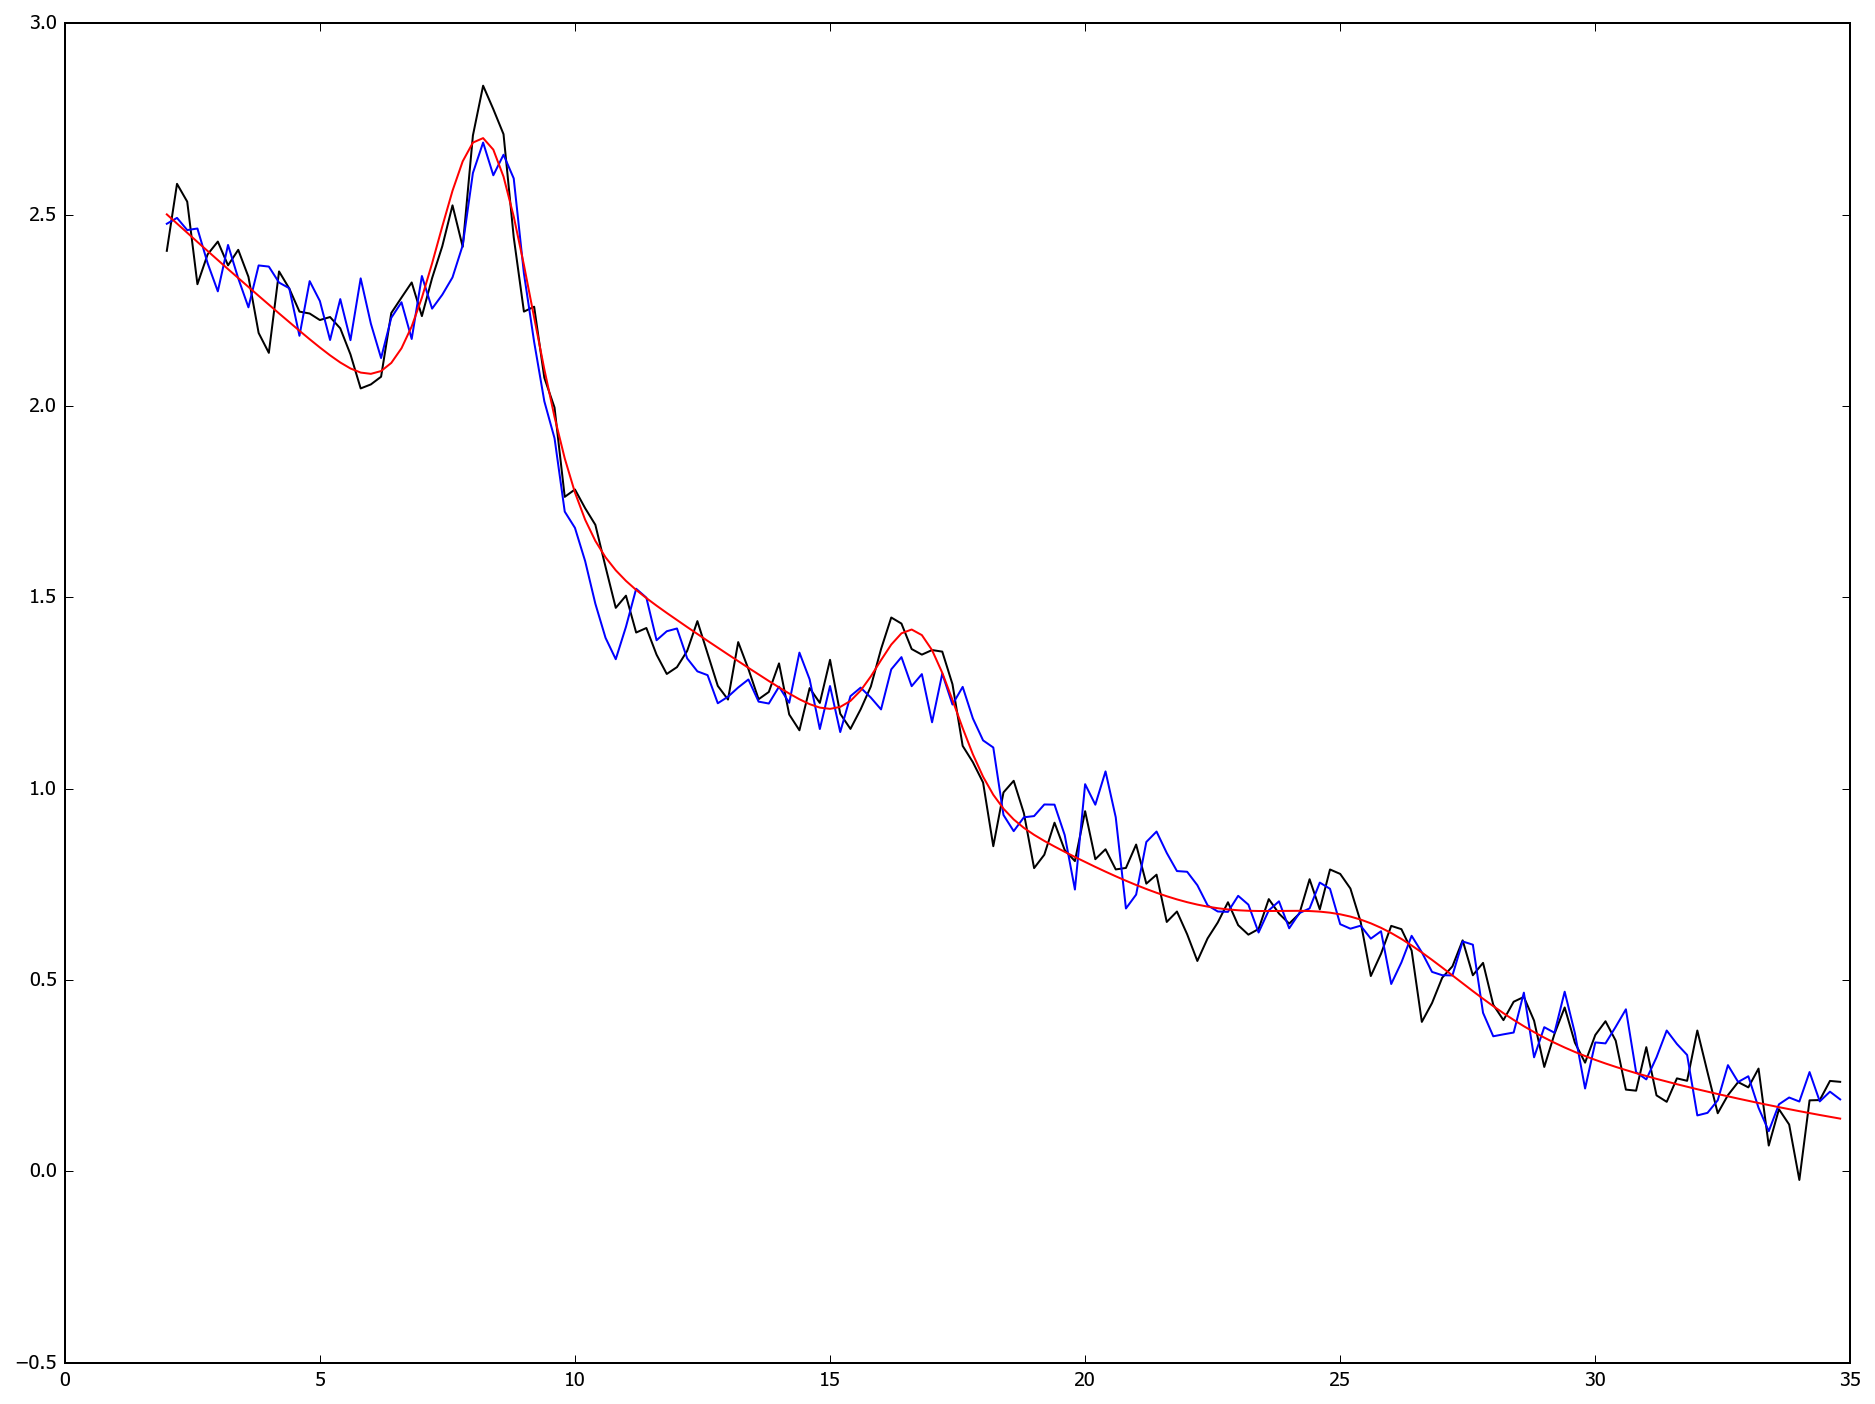

In [541]:
number_of_gaussians = 8

frequency_vector, psd_fit, background_fit, gaussian_fit, psd_train, psd_test, background_params, oscillation_params, fit_r2 = \
    fooof(xf, psd_array, cut_freqs, proportion_test, number_of_gaussians)

print(background_params)
print(oscillation_params)

plt.plot(frequency_vector, psd_train, 'k')
plt.plot(frequency_vector, psd_test, 'b')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()


In [448]:
fu.std_to_bw(popt[2])

NameError: name 'popt' is not defined

In [529]:
fit_r2

array([ 0.89391679,  0.97605056,  0.98122689,  0.98445175,  0.98379599,
        0.98379599,  0.98379599,  0.98379599,  0.98379599])